In [1]:
import sys, os, re
from glob import glob
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',70)
sys.path.insert(0, '/Users/SRIWOPE/Documents/python/config/')
from edw_wallet import *

sys.path.insert(0, '/Users/SRIWOPE/Documents/python/script/')
from run_query import run_sql

from datetime import datetime
from typing import Dict, Any, Tuple, List

import copy 
import hashlib

import joblib

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from data_processing import DataProcessor

run_sql took 1.20 minutes to run.


In [3]:
ls results/models/

cat_model.joblib               model_params.joblib
data_processor.joblib          rf_model.joblib
feature_importances.joblib     stacked_ensemble_model.joblib
gb_model.joblib                voting_ensemble_model.joblib
lgb_model.joblib               xgb_model.joblib


In [4]:
model_path = 'results/models/'
loaded_model = joblib.load(model_path+'rf_model.joblib')
loaded_model

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [12]:

stack_loaded_model = joblib.load(model_path+'stacked_ensemble_model.joblib')
stack_loaded_model

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(bootstrap=False,
                                                     max_features='sqrt',
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=9,
                                                         min_samples_split=5,
                                                         n_estimators=500,
                                                         random_state=42,
                                                         subsample=0.8)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(force_col_wise=True, max_depth=9,
                                             min_child_weight=3,
                                             min_data_in_leaf=10,
                                             n_estimators=1000, random_state=42,
                                             verbose=-1)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x33c604eb0>)],
                  final_estimator=Ridge(), n_jobs=-1)

In [14]:
xgb_loaded_model = joblib.load(model_path+'xgb_model.joblib')
xgb_loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Available models with feature importances: ['rf', 'gb', 'xgb', 'lgb', 'cat']

Top 10 most important features (Random Forest):
COMPANY_CODE_XO         0.136354
MARKET_TIER_COMBO       0.131414
SALES_TIER              0.098122
CIRCUIT_AGE_DAYS        0.071237
FIRST_LGNTD             0.041486
FIRST_LAT               0.040404
LVL_4_PRD_NM            0.035792
ENDPOINT_DISTANCE_KM    0.031540
MARGIN                  0.025815
REV_TYPE_FLAG_C         0.025584
dtype: float64

Top 10 most important features (XGBoost):
COMPANY_CODE_XO              0.673787
CIR_TECH_TYPE_WIRELESS       0.077992
CIR_TECH_TYPE_TDM            0.075118
FIRST_ADDR_TYPE_CODE_SITE    0.042869
TECH_ONNET_COMBO             0.023206
MARKET_TIER_COMBO            0.015818
COST_TYPE_FLAG_S             0.011111
REV_TYPE_FLAG_C              0.010565
IN_FOOTPRINT_Y               0.005707
LOG_PORT_SPEED               0.003926
dtype: float32

Top 10 most important features (LightGradientBoost):
FIRST_LGNTD             3290
FIRST_LA

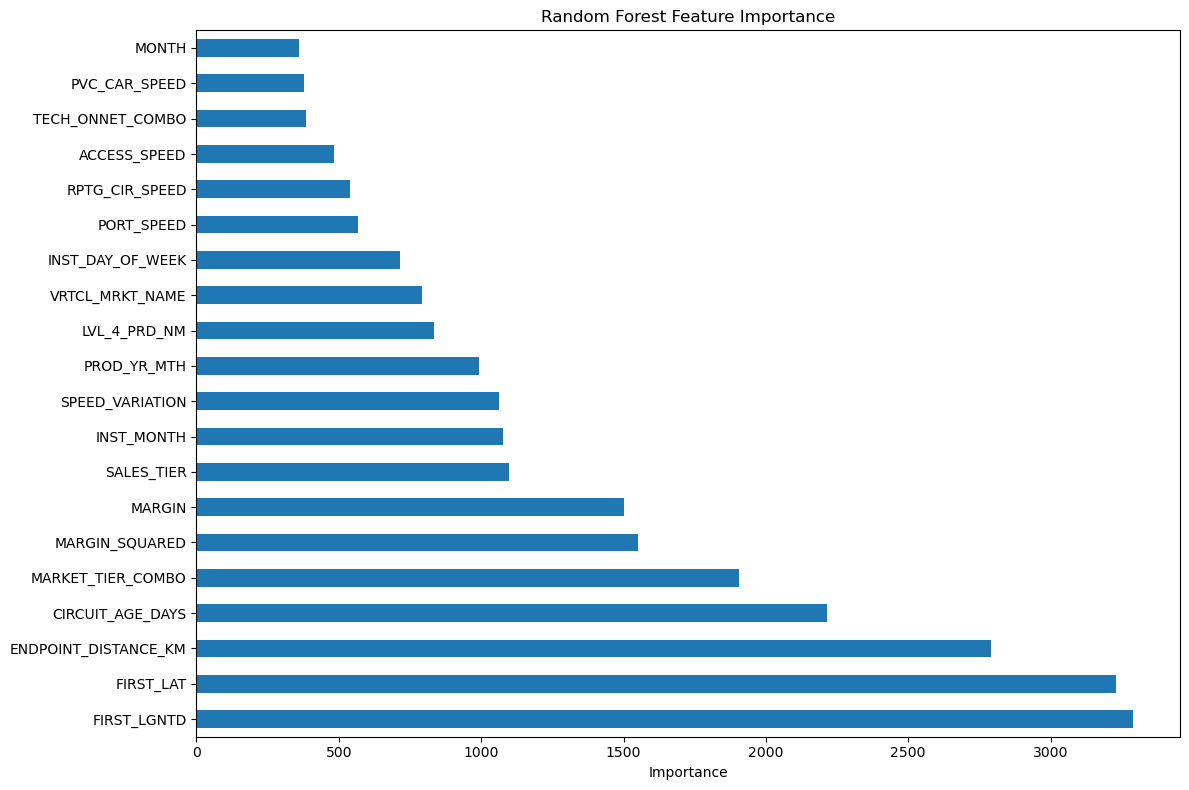

In [8]:
feature_importances = joblib.load(model_path + 'feature_importances.joblib')

# Get keys to see what models have feature importances
print("Available models with feature importances:", list(feature_importances.keys()))

# View Random Forest feature importance
rf_importance = feature_importances['rf']
print("\nTop 10 most important features (Random Forest):")
print(rf_importance.head(10))

# View XGBoost feature importance if available
if 'xgb' in feature_importances:
    xgb_importance = feature_importances['xgb']
    print("\nTop 10 most important features (XGBoost):")
    print(xgb_importance.head(10))

if 'lgb' in feature_importances:
    lgb_importance = feature_importances['lgb']
    print("\nTop 10 most important features (LightGradientBoost):")
    print(lgb_importance.head(10))

# Plot Random Forest feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
lgb_importance.head(20).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')  # Save to file
plt.show()  # Display plot

In [5]:
frn_data = run_sql('''
                    select distinct a.CIR_ID,a.NASP_ID, NASP_NM, DOM_INTL_FLAG,	INT_EXT_FLAG,	LVL_4_PRD_NM,CIR_INST_DATE,CIR_DISC_DATE,VRTCL_MRKT_NAME,
                    SALES_TIER,	SR_CRCTP,	RPTG_CRCTP,	RPTG_CIR_SPEED,	ACCESS_SPEED,	ACCESS_SPEED_UP,	
                    PORT_SPEED,	PVC_CAR_SPEED,		ACCESS_DISC,		PORT_DISC,	PVC_CAR_DISC,		OTHER_DISC,	OTHER_ADJ,		
                    	TOTAL_REV-(TOTAL_COST + OCC_COST_NONAFLT_M6364) MARGIN,
                    
                    
                    REV_TYPE_FLAG,	COST_TYPE_FLAG,	FIRST_ADDR_TYPE_CODE,
                    FIRST_CITY,	FIRST_STATE,	FIRST_ZIP,
                    FIRST_ONNET,	FIRST_INREGION,	FIRST_XOLIT,	FIRST_LATA,
                    ONNET_PROV,	COMPANY_CODE,	VRD_FLAG,	OPCO_REV,	IN_FOOTPRINT,	NASP_TYPE,
                    CIR_TECH_TYPE,	CIR_BILL_TYPE,	PROGRAM,	VENDOR,
                    BIZ_CASE, FIRST_LAT,	FIRST_LGNTD,
                    SECOND_LAT,	SECOND_LGNTD,	IEN_PROV,	DIV_PORT,	DIV_ACCESS, PROD_YR_MTH
                           
                           from edw_sr_vw.rt_cir_single_row_addr a
                           
                
                    where 
                    PROD_YR_MTH = 202501
                    and VENDOR like '%FRN%'
                    and CIR_ID in (sel CIR_ID from EDW_GLOB_OPS_VW.CIRCUIT_TDM_TD_VW
                                        where DISCO_ORD_NUM is null
                                        group by CIR_ID)
                    
 
                    
                    ''')

run_sql took 12.46 seconds to run.


In [6]:
preprocessor_data = joblib.load(model_path+'data_processor.joblib')
preprocessor = DataProcessor(random_state=preprocessor_data['random_state'])


In [7]:
preprocessor.robust_scaler = preprocessor_data['robust_scaler']
preprocessor.standard_scaler = preprocessor_data['standard_scaler']

preprocessor.target_encoder = preprocessor_data['target_encoder']
preprocessor.knn_imputer = preprocessor_data['knn_imputer']

In [10]:
frn_data['DISCO_DURATION'] = 0

processed_data = preprocessor.preprocess_data(frn_data, is_training = False)
if 'DISCO_DURATION' in processed_data.columns:
    processed_data = processed_data.drop(columns=['DISCO_DURATION'])


Starting data preprocessing...
After distribution - Target column has 1045 non-NaN values out of 1045 rows
Engineering features...
Feature engineering complete. New shape: (1045, 92)
After feature engineering - Target column NaN count: 0
Before one-hot encoding - Target column exists: True
  Target column type: int64
  Target column non-NaN values: 1045
Categorical columns to encode: ['DOM_INTL_FLAG', 'INT_EXT_FLAG', 'REV_TYPE_FLAG', 'COST_TYPE_FLAG', 'FIRST_ADDR_TYPE_CODE', 'FIRST_ONNET', 'FIRST_INREGION', 'FIRST_XOLIT', 'ONNET_PROV', 'COMPANY_CODE', 'VRD_FLAG', 'OPCO_REV', 'IN_FOOTPRINT', 'NASP_TYPE', 'CIR_TECH_TYPE', 'CIR_BILL_TYPE', 'PROGRAM', 'BIZ_CASE', 'IEN_PROV', 'DISTANCE_BUCKET', 'RPTG_CIR_SPEED_TIER', 'ACCESS_SPEED_TIER', 'PORT_SPEED_TIER', 'PVC_CAR_SPEED_TIER', 'SPEED_TIER', 'TECH_BILL_COMBO']
After one-hot encoding - Target column exists: True
  Target column non-NaN values: 1045
Preprocessing complete. Final shape: (1045, 112)
After distribution - Target column NaN count:

In [15]:
predictions = xgb_loaded_model.predict(precessed_data)

ValueError: feature_names mismatch: ['LVL_4_PRD_NM', 'VRTCL_MRKT_NAME', 'SALES_TIER', 'SR_CRCTP', 'RPTG_CRCTP', 'RPTG_CIR_SPEED', 'ACCESS_SPEED', 'PORT_SPEED', 'PVC_CAR_SPEED', 'MARGIN', 'FIRST_LAT', 'FIRST_LGNTD', 'PROD_YR_MTH', 'MONTH', 'VENDOR_COUNT', 'MONTH_SIN', 'MONTH_COS', 'CIRCUIT_AGE_DAYS', 'INST_MONTH', 'INST_DAY_OF_WEEK', 'ENDPOINT_DISTANCE_KM', 'SPEED_RATIO', 'SPEED_VARIATION', 'MAX_SPEED', 'TECH_ONNET_COMBO', 'MARKET_TIER_COMBO', 'MARGIN_SQUARED', 'LOG_MARGIN', 'LOG_ACCESS_SPEED', 'LOG_PORT_SPEED', 'REV_TYPE_FLAG_C ', 'COST_TYPE_FLAG_C ', 'COST_TYPE_FLAG_S ', 'FIRST_ADDR_TYPE_CODE_SITE', 'FIRST_ADDR_TYPE_CODE_Z', 'FIRST_ONNET_Y ', 'FIRST_INREGION_OR', 'FIRST_XOLIT_Y ', 'COMPANY_CODE_XO', 'IN_FOOTPRINT_N ', 'IN_FOOTPRINT_Y ', 'CIR_TECH_TYPE_TDM', 'CIR_TECH_TYPE_WIRELESS', 'PROGRAM_NO ACTION', 'ACCESS_SPEED_TIER_Low', 'ACCESS_SPEED_TIER_Medium', 'PORT_SPEED_TIER_Medium', 'PVC_CAR_SPEED_TIER_Low', 'PVC_CAR_SPEED_TIER_Medium'] ['LVL_4_PRD_NM', 'VRTCL_MRKT_NAME', 'SALES_TIER', 'SR_CRCTP', 'RPTG_CRCTP', 'RPTG_CIR_SPEED', 'ACCESS_SPEED', 'PORT_SPEED', 'PVC_CAR_SPEED', 'ACCESS_DISC', 'PORT_DISC', 'PVC_CAR_DISC', 'OTHER_DISC', 'OTHER_ADJ', 'MARGIN', 'FIRST_LAT', 'FIRST_LGNTD', 'PROD_YR_MTH', 'DISCO_DURATION', 'MONTH', 'YEAR', 'IS_QUARTER_END', 'IS_YEAR_END', 'VENDOR_COUNT', 'MONTH_SIN', 'MONTH_COS', 'CIRCUIT_AGE_DAYS', 'INST_MONTH', 'INST_QUARTER', 'INST_DAY_OF_WEEK', 'ENDPOINT_DISTANCE_KM', 'SPEED_RATIO', 'SPEED_VARIATION', 'MAX_SPEED', 'TOTAL_DISC', 'HAS_MULTIPLE_DISC', 'ACCESS_DISC_RATE', 'PORT_DISC_RATE', 'DISCONNECT_COMPLEXITY', 'MARGIN_SPEED_INTERACTION', 'MARGIN_DISCONNECT_RATIO', 'TECH_ONNET_COMBO', 'MARKET_TIER_COMBO', 'MARGIN_SQUARED', 'LOG_MARGIN', 'ACCESS_SPEED_SQUARED', 'LOG_ACCESS_SPEED', 'PORT_SPEED_SQUARED', 'LOG_PORT_SPEED', 'TOTAL_DISC_SQUARED', 'LOG_TOTAL_DISC', 'DOM_INTL_FLAG_I ', 'INT_EXT_FLAG_I ', 'REV_TYPE_FLAG_C ', 'REV_TYPE_FLAG_P ', 'COST_TYPE_FLAG_C ', 'COST_TYPE_FLAG_S ', 'FIRST_ADDR_TYPE_CODE_1', 'FIRST_ADDR_TYPE_CODE_2', 'FIRST_ADDR_TYPE_CODE_A', 'FIRST_ADDR_TYPE_CODE_O', 'FIRST_ADDR_TYPE_CODE_ORIG', 'FIRST_ADDR_TYPE_CODE_SITE', 'FIRST_ADDR_TYPE_CODE_SVC', 'FIRST_ADDR_TYPE_CODE_T', 'FIRST_ADDR_TYPE_CODE_Z', 'FIRST_ONNET_Y ', 'FIRST_INREGION_OR', 'FIRST_XOLIT_Y ', 'COMPANY_CODE_XO', 'VRD_FLAG_M ', 'VRD_FLAG_V ', 'OPCO_REV_EMEA', 'OPCO_REV_USOPS', 'IN_FOOTPRINT_N ', 'IN_FOOTPRINT_Y ', 'NASP_TYPE_INTERNAL', 'CIR_TECH_TYPE_EOTDM', 'CIR_TECH_TYPE_ETHERNET', 'CIR_TECH_TYPE_OTHER', 'CIR_TECH_TYPE_TDM', 'CIR_BILL_TYPE_INTERNAL', 'PROGRAM_CARRIER MGT', 'PROGRAM_NO ACTION', 'PROGRAM_NO REVENUE', 'PROGRAM_TDM TO ETHERNET', 'DISTANCE_BUCKET_Close', 'DISTANCE_BUCKET_Medium', 'DISTANCE_BUCKET_Far', 'DISTANCE_BUCKET_Very_Far', 'RPTG_CIR_SPEED_TIER_Low', 'RPTG_CIR_SPEED_TIER_Medium', 'RPTG_CIR_SPEED_TIER_High', 'RPTG_CIR_SPEED_TIER_Very High', 'ACCESS_SPEED_TIER_Low', 'ACCESS_SPEED_TIER_Medium', 'ACCESS_SPEED_TIER_High', 'ACCESS_SPEED_TIER_Very High', 'PORT_SPEED_TIER_Low', 'PORT_SPEED_TIER_Medium', 'PORT_SPEED_TIER_High', 'PVC_CAR_SPEED_TIER_Low', 'PVC_CAR_SPEED_TIER_Medium', 'SPEED_TIER_Medium', 'SPEED_TIER_High', 'SPEED_TIER_Ultra', 'TECH_BILL_COMBO_EOTDM_EXTERNAL', 'TECH_BILL_COMBO_ETHERNET_EXTERNAL', 'TECH_BILL_COMBO_OTHER_EXTERNAL', 'TECH_BILL_COMBO_OTHER_INTERNAL', 'TECH_BILL_COMBO_TDM_EXTERNAL', 'TECH_BILL_COMBO_TDM_INTERNAL']
expected CIR_TECH_TYPE_WIRELESS in input data
training data did not have the following fields: RPTG_CIR_SPEED_TIER_High, PORT_SPEED_TIER_Low, TECH_BILL_COMBO_OTHER_INTERNAL, DISCONNECT_COMPLEXITY, DOM_INTL_FLAG_I , TECH_BILL_COMBO_TDM_EXTERNAL, DISCO_DURATION, CIR_TECH_TYPE_EOTDM, FIRST_ADDR_TYPE_CODE_T, PORT_SPEED_TIER_High, FIRST_ADDR_TYPE_CODE_A, ACCESS_DISC, FIRST_ADDR_TYPE_CODE_ORIG, INT_EXT_FLAG_I , MARGIN_DISCONNECT_RATIO, PROGRAM_NO REVENUE, DISTANCE_BUCKET_Close, VRD_FLAG_V , TECH_BILL_COMBO_TDM_INTERNAL, SPEED_TIER_High, VRD_FLAG_M , HAS_MULTIPLE_DISC, TECH_BILL_COMBO_EOTDM_EXTERNAL, PORT_DISC_RATE, RPTG_CIR_SPEED_TIER_Low, TOTAL_DISC_SQUARED, ACCESS_SPEED_TIER_Very High, RPTG_CIR_SPEED_TIER_Medium, FIRST_ADDR_TYPE_CODE_SVC, PORT_SPEED_SQUARED, ACCESS_SPEED_SQUARED, SPEED_TIER_Ultra, LOG_TOTAL_DISC, FIRST_ADDR_TYPE_CODE_2, ACCESS_DISC_RATE, RPTG_CIR_SPEED_TIER_Very High, TOTAL_DISC, OTHER_DISC, ACCESS_SPEED_TIER_High, NASP_TYPE_INTERNAL, PORT_DISC, PROGRAM_TDM TO ETHERNET, PROGRAM_CARRIER MGT, DISTANCE_BUCKET_Very_Far, IS_QUARTER_END, TECH_BILL_COMBO_ETHERNET_EXTERNAL, IS_YEAR_END, SPEED_TIER_Medium, MARGIN_SPEED_INTERACTION, FIRST_ADDR_TYPE_CODE_O, TECH_BILL_COMBO_OTHER_EXTERNAL, CIR_TECH_TYPE_ETHERNET, INST_QUARTER, OPCO_REV_USOPS, DISTANCE_BUCKET_Far, REV_TYPE_FLAG_P , OPCO_REV_EMEA, YEAR, OTHER_ADJ, CIR_TECH_TYPE_OTHER, PVC_CAR_DISC, DISTANCE_BUCKET_Medium, CIR_BILL_TYPE_INTERNAL, FIRST_ADDR_TYPE_CODE_1